# Silver EDA — SRAG Cases

This notebook explores the **Silver** layer (`silver.cases`) of the SRAG dataset.
It connects to DuckDB in read-only mode, runs sanity checks, and plots a few key distributions.

**Notes**
- The database path is resolved from the `DUCKDB_PATH` environment variable or defaults to `data/srag.duckdb`.
- All queries use `duckdb` and return `pandas` DataFrames.
- Charts use Matplotlib only.

In [17]:
import os
from pathlib import Path
import duckdb as ddb
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

def find_project_root() -> Path:
    """Walk upwards until a folder containing `pyproject.toml` is found."""
    cur = Path.cwd()
    while cur != cur.parent and not (cur / 'pyproject.toml').exists():
        cur = cur.parent
    return cur

def resolve_db_path() -> Path:
    """Resolve DuckDB absolute path from env var or default `data/srag.duckdb`."""
    db_env = os.getenv('DUCKDB_PATH', 'data/srag.duckdb')
    db_path = Path(db_env)
    if not db_path.is_absolute():
        db_path = find_project_root() / db_path
    return db_path

DB_PATH = resolve_db_path()
print('Using DB:', DB_PATH)
assert DB_PATH.exists(), f'DB not found at: {DB_PATH}'

con = ddb.connect(str(DB_PATH), read_only=True)

def q(sql: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query and return a pandas DataFrame."""
    return con.execute(sql, params or {}).df()


Using DB: /home/ziolli/Área de trabalho/Case-Indicium/data/srag.duckdb


## What schemas/tables exist?

In [ ]:
# Schemas available
q("""
SELECT schema_name
FROM information_schema.schemata
ORDER BY 1;
""")


In [18]:
# Silver objects (tables + views)
q("""
SELECT schema_name, table_name
FROM duckdb_tables()
WHERE schema_name = 'silver'
ORDER BY 1,2;
""")


,schema_name,table_name
0,silver,cases


## Inspect `silver.cases` schema

In [19]:
q("""
SELECT column_name, data_type, is_nullable, ordinal_position
FROM information_schema.columns
WHERE table_schema = 'silver' AND table_name = 'cases'
ORDER BY ordinal_position;
""")


,column_name,data_type,is_nullable,ordinal_position
0,dt_notific,TIMESTAMP,YES,1
1,dt_sin_pri,TIMESTAMP,YES,2
2,dt_evoluca,TIMESTAMP,YES,3
3,dt_encerra,TIMESTAMP,YES,4
4,sem_not,INTEGER,YES,5
5,ano_notific,INTEGER,YES,6
6,mes_notific,DATE,YES,7
7,evolucao_code,INTEGER,YES,8
8,evolucao_label,VARCHAR,YES,9
9,classi_fin,INTEGER,YES,10


## Basic sanity: date ranges, row count

In [20]:
q("""
SELECT COUNT(*) AS rows_total,
       MIN(dt_notific) AS min_dt,
       MAX(dt_notific) AS max_dt
FROM silver.cases;
""")


,rows_total,min_dt,max_dt
0,4354925,2018-12-30,2025-09-08


## Yearly and UF summaries

In [21]:
yearly = q("""
SELECT ano_notific, COUNT(*) AS rows
FROM silver.cases
GROUP BY ano_notific
ORDER BY ano_notific;
""")
yearly


,ano_notific,rows
0,2018,3
1,2019,48637
2,2020,1148795
3,2021,1773883
4,2022,582657
5,2023,284383
6,2024,268519
7,2025,248048


In [22]:
top_uf = q("""
SELECT uf, COUNT(*) AS rows
FROM silver.cases
GROUP BY uf
ORDER BY rows DESC
LIMIT 15;
""")
top_uf


,uf,rows
0,SP,1234237
1,MG,481641
2,RJ,363866
3,PR,350664
4,RS,237425
5,CE,186576
6,SC,170463
7,PE,169526
8,BA,163326
9,GO,128660


## Null ratios for key fields

In [23]:
nulls = q("""
SELECT
  SUM(dt_notific IS NULL) * 1.0 / COUNT(*) AS null_dt_notific_ratio,
  SUM(evolucao_code IS NULL) * 1.0 / COUNT(*) AS null_evolucao_ratio,
  SUM(uti_bool IS NULL) * 1.0 / COUNT(*) AS null_uti_ratio,
  SUM(vacinado_bool IS NULL) * 1.0 / COUNT(*) AS null_vac_ratio,
  SUM(idade IS NULL) * 1.0 / COUNT(*) AS null_age_ratio
FROM silver.cases;
""")
nulls


,null_dt_notific_ratio,null_evolucao_ratio,null_uti_ratio,null_vac_ratio,null_age_ratio
0,0.0,0.075206,0.149906,0.435952,0.0


## Distributions and quick plots

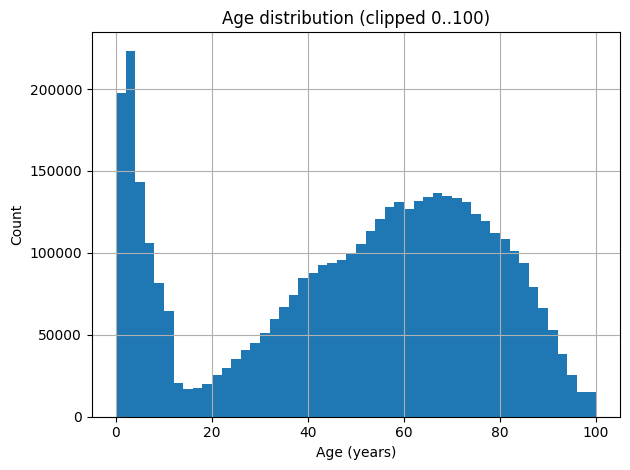

In [24]:
# Age distribution
age = q("""
SELECT idade FROM silver.cases WHERE idade IS NOT NULL;
""")['idade'].dropna()

plt.figure()
age.clip(lower=0, upper=100).hist(bins=50)
plt.title('Age distribution (clipped 0..100)')
plt.xlabel('Age (years)'); plt.ylabel('Count')
plt.tight_layout()


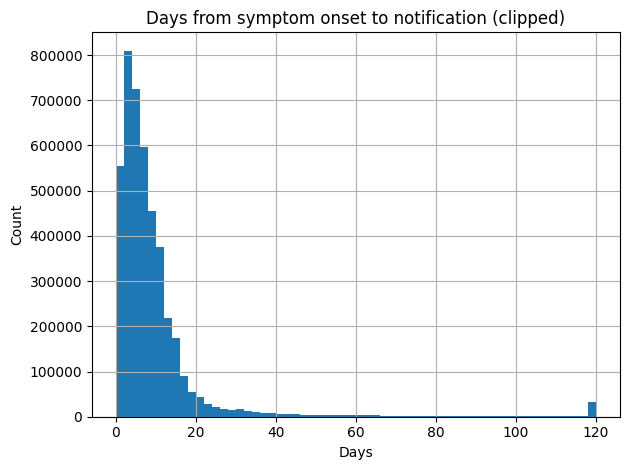

In [25]:
# Symptom -> Notification lag (days)
lags = q("""
SELECT DATEDIFF('day', dt_sin_pri, dt_notific) AS lag
FROM silver.cases
WHERE dt_sin_pri IS NOT NULL AND dt_notific IS NOT NULL;
""")['lag'].dropna()

plt.figure()
lags.clip(lower=-30, upper=120).hist(bins=60)
plt.title('Days from symptom onset to notification (clipped)')
plt.xlabel('Days'); plt.ylabel('Count')
plt.tight_layout()


In [26]:
# ICU ratio by UF (top 12 by cases)
icu_uf = q("""
WITH totals AS (
  SELECT uf, COUNT(*) AS cases, SUM(CASE WHEN uti_bool IS TRUE THEN 1 ELSE 0 END) AS icu_cases
  FROM silver.cases
  GROUP BY uf
)
SELECT uf, cases, icu_cases, 100.0 * icu_cases / NULLIF(cases, 0) AS icu_rate_pct
FROM totals
ORDER BY cases DESC
LIMIT 12;
""")
icu_uf


,uf,cases,icu_cases,icu_rate_pct
0,SP,1234237,359312.0,29.112075
1,MG,481641,116677.0,24.224889
2,RJ,363866,134012.0,36.830042
3,PR,350664,96842.0,27.616750
4,RS,237425,71553.0,30.137096
5,CE,186576,37258.0,19.969342
6,SC,170463,39930.0,23.424438
7,PE,169526,36674.0,21.633260
8,BA,163326,63742.0,39.027467
9,GO,128660,50615.0,39.340121
